<center>
<h2>IPM-407: Modelación Computacional con Algoritmos Rápidos</h2>
<h3>Project 3 - Fast Gauss Transform</h3>
<h4>Daniel San Martín</h4>
</center>

## 1. Introduction

The direct evaluation of the sum of $N$ Gaussians at $M$ points require a lot amount of work and grows as $N$ and $M$ increase, $O(NM)$. The *Fast Gauss Transform* try to decrease the order of complexity to $O(M+N)$, depending only of the precision required. This algorithm is based on a divide-and-conquer strategy, combined with the manipulation of *Hermite expansions* and *Taylor series*.

### 1.1 Gauss Transform

Many problems in applied mathematics involve the *Gauss Transform*

\begin{equation}
    \displaystyle
    G_{\delta}f(x) = \int_{\Gamma}e^{-|x-y|^2/\delta}f(y)dy \quad (\delta > 0)
\end{equation}

of a function $f$ defined on $\Gamma \subset \mathbb{R}^d$.

### 1.2 Discrete Gauss Transform 

For numerical purposes, one must discretize $G_{\delta}f$. Given the values of $f$ at a set of points $s_j \in\mathbb{R}^d$, we can approximate the integral using a quadrature formula. Then, a reasonable approximation of $G_{\delta}f$ might then take the form of a *discrete Gauss transform*

\begin{equation}
    \displaystyle
    G(x) = \sum_{j=1}^N q_j e^{-|x-s_j|^2/\delta},
\end{equation}

where the coefficients $q_j$ depend of the values $f(s_j)$ and the weights of the chosen quadrature formula.

### 1.3 Hermite expansions

The Hermite polynomials $H_n(t)$ may be defined by the Rodrigues formula

\begin{equation}
\displaystyle
    H_n(t) = (-1)^2 e^{t^2} D^ne^{-t^2}, \quad t\in\mathbb{R},
\end{equation}

where $D=d/dt$. Using the generating function for the Hermite polynomials and making an algebraic manipulation it's possible to show that

\begin{equation}
\displaystyle
    e^{-(t-s)^2} = \sum_{n=0}^{\infty} \frac{s^n}{n!}h_n(t),
\end{equation}

where the Hermite functions $h_n(t)$ are defined by
\begin{equation}
\displaystyle
    h_n(t) = e^{-t^2}H_n(t).
\end{equation}

## 2. Content

Libraries and common functions.

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.special import hermite
from scipy.misc import factorial
from point2d import *

In [2]:
# Generate sources
def gen_sources(N):
    r = [None]*N
    for i in range(len(r)):
        X = np.random.random()
        Y = np.random.random()
        gamma = np.random.random()
        r[i] = point2d(X, Y, gamma,i)
    return r

In [3]:
# Generate targets
def gen_targets(N):
    r = [None]*N
    for i in range(N):
        X = np.random.random()
        Y = np.random.random()
        r[i] = point2d(X, Y, 0, i)
    return r

In [4]:
def L2_error(w, u):
    return np.sqrt(np.sum((w-u)**2)/np.sum(u**2))

In [5]:
# Convergence plot
def convergence_plot(N, error):    
    plt.figure(figsize=(10, 6))
    plt.loglog(N, error, 'b-*', label="Error")
    plt.title("Convergencia del error")
    plt.xlabel("N")
    plt.ylabel("Error")
    plt.grid(True)
    plt.legend()
    plt.show()
    
    return None

In [6]:
# Complexity plot
def complexity_plot(N, time_DGT, time_FGT):
    plt.figure(figsize=(10, 6))
    plt.loglog(N, time_DGT, 'b-*', label="DGT")
    plt.loglog(N, time_FGT, 'r-o', label="FGT")
    plt.title("Complejidad")
    plt.xlabel("N")
    plt.ylabel("Tiempo")
    plt.grid(True)
    plt.legend()
    plt.show()
    
    return None

In [7]:
# Plot sources, targets and potential
def plot(s, t, r):
    sX = np.zeros(len(s))
    sY = np.zeros(len(s))
    tX = np.zeros(len(t))
    tY = np.zeros(len(t))
    
    for i in range(len(s)):
        sX[i] = s[i].x
        sY[i] = s[i].y
        
    for i in range(len(t)):
        tX[i] = t[i].x
        tY[i] = t[i].y
        
    area = 100 * np.pi * r**2
    
    plt.figure(figsize=(16, 10))
    plt.plot(sX, sY, 'ko', label="Sources")
    plt.plot(tX, tY, 'kx', label="Targets")
    plt.scatter(tX, tY, c = r, marker = 'o', s = area, cmap=cm.jet, alpha=0.5)
    plt.colorbar()
    plt.legend()
    plt.show()

### Naive Gauss Transform

Let a set of targets $t_i$ and sources $s_i$ the *Discrete Gauss Transform* is defined by:

\begin{equation}
\displaystyle
    G(t_i) = \sum_{j=1}^N q_je^{-|t_i-s_j|^2/\delta}, \quad i=1,...M
\end{equation}

In [8]:
# Discrete Gauss Transform
def DGT(s, t, delta):
    r = np.zeros(len(t))
    
    for i in range(len(t)):
        for j in range(len(s)):
            dist = (s[j]-t[i]).norm()
            v = dist**2 / delta
            r[i] += s[j].gamma*np.exp(-v)
            
    return r

In [9]:
# Direct Gaussian evaluation for FGT
def direct_gaussian(s, t, delta, results):
    """
    Direct calculation of Gaussians
    
    Input: 
        - s: Source points
        - t: Target points
        - delta: Gaussian width
        - results: Array to update
    
    """
    for i in range(len(t)):
        r = 0
        
        # index of the target point - element of results to store in
        idx = t[i].idx

        for j in range(len(s)):
            dist = (s[j]-t[i]).norm()
            v = dist**2 / delta
            r += s[j].gamma*np.exp(-v)
            
        results[idx] += r
        
    return results

### Multidimensional Extension

Let $t$ and $s$ lie in $d$-dimensional Euclidean space $\mathbb{R}^d$, and consider the Gaussian

\begin{equation}
\displaystyle
    e^{-|t-s|^2} = e^{-(t_1-s_1)^2 - ... - (t_d-s_d)^2}.
\end{equation}

A multi-index $\alpha=(\alpha_1, \alpha_2, ..., \alpha_d)$ is a $d$-duple of nonnegative integers, playing role of a multidimensional index. For any multi-index $\alpha$ and any
$t\in\mathbb{R}^d$, we define

\begin{equation}
\displaystyle
\begin{split}
    |\alpha| & = \alpha_1 + \alpha_2 + ... + \alpha_d,\\ 
    \alpha ! & = \alpha_1!\alpha_2!...\alpha_d !, \\
    t^{\alpha} & = t_1^{\alpha_1}t_2^{\alpha_2}...t_d^{\alpha_d}, \\
    D^{\alpha} &= \partial_1^{\alpha_1}\partial_2^{\alpha_2}...\partial_d^{\alpha_d}
\end{split}
\end{equation}

where $\partial_i$ is differentation with respect to the $i$th coordinate in $\mathbb{R}^d$. If $p$ is an integer, we say $\alpha \geq p$ if $\alpha_i \geq p$ for $1\leq i \leq d$.

The multidimensionales Hermite polynomials and Hermite functions are then defined by

\begin{equation}
\displaystyle
    H_{\alpha}(t) = H_{\alpha_1}(t_1) ... H_{\alpha_d}(t_d),
\end{equation}
and,

\begin{equation}
\displaystyle
    h_{\alpha}(t) = e^{-|t|^2}H_{\alpha}(t) = h_{\alpha_1}(t_1) ... h_{\alpha_d}(t_d),
\end{equation}

respectively, where $|t|^2 = t_1^2+...+t_d^2$.

<!--Luego, la \emph{expansión de Hermite} de una Gaussiana en $\mathbb{R}^d$ es
\begin{equation}
    e^{-|t-s|^2} = \sum_{\alpha \geq 0} \frac{(t-s_0)^{\alpha}}{\alpha !}h_{\alpha}(s-s_0).
\end{equation}-->

In [10]:
# |alpha|
def abs_alpha(alpha):
    return np.sum(alpha)

In [11]:
# alpha!
def fact_alpha(alpha):
    return np.prod(factorial(alpha))

In [12]:
# Generate multi-index alpha
def gen_alpha(p):
    alpha = []
    for i in range(p):
        for j in range(p-i):
            alpha.append([i,j])
    return alpha

In [13]:
def build_fact_cache(q):
    f = np.zeros(q+1)
    for i in range(q+1):
        f[i] = factorial(i)
    return f

### Convert box's sources to Hermite series about center of box

*Lemma 2.1* Let $N_B$ sources $s_j$ lie in a box $B$ with center $s_B$ and side length $r\sqrt{2\delta}$ with $r < 1$. Then the Gaussian field due to the sources in $B$,

\begin{equation}
\displaystyle 
    G(t) = \sum_{j=1}^{N_B}q_je^{-|t-s_j|^2/\delta},
\end{equation}

is equal to a single Hermite expansion about $s_B$:

\begin{equation}
\displaystyle 
    G(t) = \sum_{\alpha\geq 0} A_{\alpha}h_{\alpha}\left(\frac{t-s_B}{\sqrt{\delta}}\right)
\end{equation}

The coefficients $A_{\alpha}$ are given by

\begin{equation}
\displaystyle 
    A_{\alpha} = \frac{1}{\alpha !}\sum_{j=1}^{N_B}q_j\left(\frac{s_j - s_B}{\sqrt{\delta}}\right)^{\alpha}
\end{equation}

In [14]:
def eval_hermite(A_alpha, t, sb, delta, alpha, H):
    """
    Evaluate hermite expansion at a target point
    
    Inputs:
        - A_alpha: List of A series coefficients
        - t: Target point
        - sb: Center of source cluster (series center)
        - delta: Gaussian width
        - alpha: Alpha multi-index
        - H: List of pre-computed hermite polynomials
    """
    r = 0.
    for i in range(len(alpha)):
        x = (t-sb) / sqrt(delta)
        pre_mult = A_alpha[i]*np.exp(-(x.x**2 + x.y**2))
        r  += pre_mult * H[alpha[i][0]](x.x) * H[alpha[i][1]](x.y)
    
    return r

In [15]:
def A_alpha(s, sb, delta, alpha):
    """
    Build A_alpha coefficients
    
    Inputs:
        - s: Source points
        - q: Source strengths
        - sb: Center of cluster
        - delta: Gaussian width
        - alpha: alpha multi-index
    Return:
        - A: array of coefficients
    """
    A = np.zeros(len(alpha))

    # Go over each alpha value
    for i in range(len(alpha)):
        alp_temp = alpha[i]
        A_tmp = 0.
        
        # Sum over all the source points
        for j in range(len(s)):
            A_tmp += s[j].gamma * ((s[j] - sb) / math.sqrt(delta))**alp_temp
            
        A[i] = A_tmp / (1.*fact_alpha(alp_temp))
    return A

### Hermite to Taylor Expansion

To convert a Hermite expansion about $s_B$ into Taylor expanson about $t_C$. The Taylor series converfes rapidily in a box of side $r\sqrt{2\delta}$ about $t_C$, whit $r<1$.

*Lemma 2.2*. The Hermite expansion

\begin{equation}
\displaystyle
    G(t) = \sum_{\alpha\geq 0} A_{\alpha}h_{\alpha}\left(\frac{t-s_B}{\sqrt{\delta}}\right)
\end{equation}

has the following Taylor expansion, about an arbitrary point $t_C$:

\begin{equation}
\displaystyle
    G(t) = \sum_{\beta\geq 0} B_{\beta}\left(\frac{t-t_C}{\sqrt{\delta}}\right)^{\beta}.
\end{equation}

The coefficients $B_{\beta}$ are given by

\begin{equation}
\displaystyle
    B_{\beta} = \frac{(-1)^{|\beta|}}{\beta !}\sum_{\alpha\geq 0} A_{\alpha}h_{\alpha+\beta}\left(\frac{s_B-t_C}{\sqrt{\delta}}\right).
\end{equation}

### Truncated Hermite series to Taylor series

The algorithm needs a variant of *Lemma 2.2* in which the Hermite series is truncated before converting it to a Taylor series. This essentially means that in addition to truncating the Taylor series itself, we are also truncating the infinite sum expression for the coefficients. Fortunately, however, the error due to this approximation of the coefficients turns out to be much smaller than the truncation error of the Taylor series.

*Lemma 2.3.* A truncated Hermite expansion

\begin{equation}
\displaystyle 
    G(t) = \sum_{\alpha\leq p}A_{\alpha}h_{\alpha}\left(\frac{t-s_B}{\sqrt{\delta}}\right)
\end{equation}

has the following Taylor expansion about an arbitrary point $t_C$:

\begin{equation}
\displaystyle 
    G(t) = \sum_{\beta\geq 0}C_{\beta}\left(\frac{t-t_C}{\sqrt{\delta}}\right)^{\beta}.
\end{equation}

The coefficients $C_{\beta}$ are given by

\begin{equation}
\displaystyle 
    C_{\beta} = \frac{(-1)^{|\beta|}}{\beta !}\sum_{\alpha\leq p}A_{\alpha}h_{\alpha + \beta}\left(\frac{s_B-t_C}{\sqrt{\delta}}\right).
\end{equation}

In [16]:
def C_beta(sb, tc, A, delta, p, q, alpha, beta, H):
    """
    Translate hermite series about sources into taylor series about target cluster center 
    (doesn't depend on source pts)
    
    Inputs: 
        - sb: Old cluster center
        - tc: New center of series
        - A: Array of A_alpha values for cluster with center sb
        - delta:
        - beta: Beta multi-index
        - H: List of pre-computed hermite polynomials

    Return:
        - C: array of coefficientes
    """
    C = np.zeros(len(beta))
    
    for i in range(len(beta)):
        sign  = ((-1.)**(1.*abs_alpha(beta[i]))) / (1. * fact_alpha(beta[i]))
        B_tmp = 0.
        
        # iterate over A_alpha values
        for j in range(len(A)):
            a = A[j]
            x = (sb-tc) / math.sqrt(delta)
            t = (x.x)**2 + (x.y)**2
            
            #h1 = H[alpha[j, 0] + beta[i, 0]](x.x)
            #h2 = H[alpha[j, 1] + beta[i, 1]](x.y)
            h1 = H[alpha[j][0] + beta[i][0]](x.x)
            h2 = H[alpha[j][1] + beta[i][1]](x.y)

            B_tmp += a*np.exp(-t)*h1*h2
        C[i] = B_tmp*sign
    
    return C

Rather than using *Lemma 2.1* to accumulate all the Gaussians into a single Hermite expansion and then shifting it to $t_C$, we can use *Lemma 2.3* to shift each Gaussian individually to $t_C$ and add up the resulting Taylor coefficients. (A Gaussian is a one-term Hermite series, after all, and can therefore be shifted just like any other truncated Hermite series.) Thus, a Gaussian

\begin{equation}
\displaystyle 
    G(t) = qe^{-|t-s_j|^2/\delta}
\end{equation}

has the following Taylor expansion about $t_C$:

\begin{equation}
\displaystyle 
    G(t) = \sum_{\beta\geq 0}B_{\beta}\left(\frac{t-t_C}{\sqrt{\delta}}\right)^{\beta}.
\end{equation}

The coefficients $B_{\beta}$ are given by

\begin{equation}
\displaystyle 
    B_{\beta} = q\frac{(-1)^{|\beta|}}{\beta !}h_{\beta}\left(\frac{s_j-t_C}{\sqrt{\delta}}\right)
\end{equation}

In [17]:
def B_beta(s, tc, delta, beta, H):
    """
    Directly get taylor coefficients for target cluster rather than translate from hermite series
    
    Inputs:
        - s: Source points
        - tc: Center of targets' cluster
        - delta: Gaussian width
        - beta: beta multi-index coefficients
        - H: list of pre-computed hermite polynomials
        
    Return:
        - B: array of coefficients
    """
    B = np.zeros(len(beta))

    for i in range(len(beta)):
        sign = ((-1)**(1.*abs_alpha(beta[i]))) / (1.*fact_alpha(beta[i]))
        B_tmp = 0.
        
        # For each point, work out the expansion
        for j in range(len(s)):
            q = s[j].gamma
            x = (s[j]-tc) / math.sqrt(delta)

            t = ((x.x)**2) + ((x.y)**2)

            temp = np.exp(-t)*(H[beta[i][0]](x.x))*(H[beta[i][1]](x.y))
            B_tmp += q*sign*temp

        B[i] = B_tmp

    return B

### Interaction list

The interaction list is the number of boxes where exist a considerable interaction between sources and target boxes. It's defined by $(2n+1)^d$, where $d$ is the dimension of the domain.

<img src="img/boxes.png" />
<center>*Figure 1.* Interaction list.</center>

In [18]:
def int_list(A, i, j, n):
    """
    Get the interaction list from A about cluster (i,j) with a distance of n in x, y directions.

    Inputs:
        - A: Cluster index array
        - i: Cluster row
        - j: Cluster column
        - n: Number of clusters in each direction
        
    Return:
        Interaction list
    """
    if (i-n < 0): y_min = 0
    else: y_min = i - n
        
    if (j-n < 0): x_min = 0
    else: x_min = j - n
        
    return A[y_min:i+n+1, x_min:j+n+1]

In [19]:
def eval_taylor(t, tc, delta, t_series, beta):
    """
    Evaluate taylor series at a target point
    
    Inputs:
        - t: Target point
        - tc: Center of Taylor series
        - delta:
        - t_series: Taylor series coefficients
        - beta: Beta multi-index
    """
    x = (tc-t)/math.sqrt(delta)
    r = 0.
    
    for i in range(t_series.shape[1]):
        r += t_series[0,i]*(x**beta[i])

    return r

In [20]:
def gen_hermite_polys(p):
    """
    Pre-compute the hermite polynomials to be used throughout the calculations (for speed)
    
    Inputs:
        - p: number of terms kept in hermite / taylor series
    """
    H = []
    
    for i in range(p):
        H.append(hermite(i))
        
    return H

In [21]:
def nCp(n, p):
    """
    Get nCp needed for number of coefficients for taylor series
    
    Inputs:
        - n:
        - p:
    """
    top = factorial(n)
    bottom = factorial(p)*factorial(n-p)
    
    return int(1.*(top/bottom))

### Sum of q's

Sum of the potential is defined by $\displaystyle Q=\sum_{j=1}^N|q_j|$.

In [22]:
def sum_gamma(s):
    """
    Sum the gamma values to get Qb
    """
    q = 0.
    for i in s:
        q += abs(i.gamma)
        
    return q

### Parameter's cutoff based on error bound

Since the range of Gassian $e^{-|t-s|^2/\delta}$ is $O(\sqrt{\delta})$ and the boxes have side lengths $r\sqrt{2\delta}$, only a fixed number of sources $B$ can contribute more than $Q\epsilon$ to the field given a target box $C$, where $Q=\sum_{j=1}^N|q_j|$ and $\epsilon$ is a specified precision. Indeed, if we cut off the sum over all $B$ after including the $(2n+1)^d$ nearest boxes $C$, we incur an error bounded by $Qe^{-2r^2n^2}$. So we can always choose $n$ depending only on $r$ and $\epsilon$ to make this less than $Q\epsilon$.

In [23]:
# Compute cutoff parameters using error
def truncation_bound(Qb, r, eps):
    pre_mult = np.exp(-2.*(r**2))

    for n in range(10):
        e = pre_mult*np.exp(-n**2)

        if (e < eps):
            return n+1

    return n

### Hermite cutoff

The error $E_H(p)$ due to truncating the series after $p^d$ terms satisfied the bound:

\begin{equation}
\displaystyle
    \big|E_H(p)\big|=\Bigg| \sum_{\alpha\geq p} A_{\alpha}h_{\alpha}\left(\frac{t-s_B}{\sqrt{\delta}}\right)\Bigg| \leq KQ_B\left(\frac{1}{p!}\right)^{d/2}\left(\frac{r^{p+1}}{1-r}\right)^d,
\end{equation}

In [24]:
# Compute Hermite cutoff parameters using error
def hermite_bound(Qb, r, eps):
    K = (1.09**2)

    for p in range(50):
        e = K*Qb*(1./factorial(p))*((r**(p+1))/(1-r))
        if (e <= eps):
            return p

    return p

### Taylor cutoff

The error $E_T(p)$ due to truncating the series after $p^d$ terms satisfied the bound:

\begin{equation}
\displaystyle
    \big|E_T(p)\big|=\Bigg| \sum_{\beta\geq p} B_{\beta}\left(\frac{t-s_C}{\sqrt{\delta}}\right)^{\beta}\Bigg| \leq Kq\left(\frac{1}{p!}\right)^{d/2}\left(\frac{r^{p+1}}{1-r}\right)^d
\end{equation}

for $r<1$.

In [25]:
# Compute Hermite cutoff parameters using error
def taylor_bound(Qb,r,eps):
    K = (1.09**2)
    
    for p in range(50):
        e = K*Qb*(1./factorial(p))*((r**(p+1))/(1-r))
        if e <= eps:
            return p

    return p

In [26]:
def cluster(pts, xb, yb):

    centers = [[] for _ in range(xb*yb)]
    # initialise list for storing points
    B = [[] for _ in range(xb*yb)]

    dx = 1. / xb
    dy = 1. / yb

    x_bounds = []
    y_bounds = []

    # calculate lists of x and y bounds
    # assume domain = [0,1]^2
    for i in range(xb + 1):
        x_bounds.append(i*dx)
    for i in range(yb + 1):
        y_bounds.append(i*dy)

    # assign the cluster centers
    for i in range(yb):
        for j in range(xb):
            y_center = (y_bounds[i] + y_bounds[i+1])/2.0
            x_center = (x_bounds[j] + x_bounds[j+1])/2.0

            centers[i*yb+j] = point2d(x_center,y_center)

    # now assign points into the appropriate boxes
    for i in range(len(pts)):
        X = pts[i].x
        Y = pts[i].y

        # get y box
        for j in range(yb):
            if (Y >= y_bounds[j] and Y > y_bounds[j+1]):
                # not in this box
                continue
            if (Y >= y_bounds[j] and Y <= y_bounds[j+1]):
                y_box = j
                break

        # get x box
        for k in range(xb):
            if (X >= x_bounds[k] and X > x_bounds[k+1]):
                continue
            if (X >= x_bounds[k] and X <= x_bounds[k+1]):
                x_box = k
                break

        B[y_box*yb + x_box].append(pts[i])

    # build index array
    A = np.zeros([xb,yb], dtype=int)
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            A[i,j] = (i*xb)+j

    return A, B, centers

### The Fast Gauss Transform Algorithm

1. Choose the largest $r \leq \frac12$ such that $1/r\sqrt{2\delta}$ is an integer $N_{\text{side}}$. Subdivide the boxes into $N_{\text{side}}^d$ boxes. Choose the number $n$ of boxes to go out in each direction based on $r$ and the desired precision $\epsilon$. Each source sends to $(2n + 1)^d$ boxes. Choose the number of terms $p^d$ based on $r$ and $\epsilon$. Choose the cutoffs $N_F$ and $M_L$.
* Assign sources and targets to boxes. Determine number of boxes containing more than $M_L$ targets. For each such box, allocate storage for a Taylor series with $p^d$ terms and initialize to zero.
* Loop through boxes, computing interactions between sources in box and targets within range $n$. For each pair of source and target boxes, one of the following four options is used:
    * If $N_B < N_F$ then $B$ sends out $N_B$ Gaussians.
    * If $N_B \geq N_F$ then $B$ sends out a Hermite expansion.
    * If $M_C < M_L$ then $C$ evaluates all fields sent to it immediately.
    * If $M_C \geq M_L$ then $C$ transforms all fields sent to it into Taylor series, accumulates the coefficients, and only then evaluates the Taylor series.
    
* Loop through boxes evaluating Taylor series for boxes with more than $M_L$ targets.

In [27]:
def FGT(opt):
    
    # STEP 1
    # Get options - Parameters
    r = opt['r']
    delta = opt['delta']
    N_side = opt['N_side']
    eps = opt['eps']
    s = opt['s']
    t = opt['t']

    # Sub-box size
    xb = yb = N_side

    # Particle gamma sum
    Qb = sum_gamma(s)
    
    # Terms for hermite expansion
    p = hermite_bound(Qb, r, eps)

    # Terms for taylor expansion
    q = taylor_bound(Qb, r, eps)

    # Build a factorial cache - only compute this crap once
    fact_cache = build_fact_cache(p+q)
    
    # Generate table of hermite polynomials
    H = gen_hermite_polys(p + q)
 
    # Series' cutoffs based on error bounds
    NF = p + 1
    ML = q + 1

    
    n = truncation_bound(Qb, r, eps)

    # Cluster source and target points
    # A is the index matrix, B = source clusters, C = target clusters,
    A, B, sb = cluster(s, xb, yb)
    A, C, tb = cluster(t, xb, yb)
    
    # Generate alpha and beta multi-index vectors
    alpha = gen_alpha(p)
    beta = gen_alpha(q)

    
    # STEP 2
    
    # Storage for Taylor series and Hermite series
    h_series = [[] for _ in range(xb*yb)]
    t_series = [[] for _ in range(xb*yb)]

    # Loop over source boxes -> NB > NF: generate Hermite series
    for i in range(xb):        
        for j in range(yb):
            idx = A[i,j]

            NB  = len(B[idx])

            if (NB > NF):
                # Generation Hermite series for box (i, j)
                h_series[idx] = A_alpha(B[idx], sb[idx], delta, alpha) 
            else:
                # Don't generate Hermite series
                continue                

    # Loop over target boxes -> MC > ML: assign storage for Taylor series
    for i in range(xb):
        for j in range(yb):
            idx = A[i,j]
    
            MC = len(C[idx])
    
            if (MC > ML):
                # Assigning storage for Taylor series in box (i,j)

                # no. terms from iFGT paper, pg. 7
                t_series[idx] = np.zeros((1, nCp(q+1,2)))
            else:
                # Don't assign storage
                continue
                

    # STEP 3
    
    # Array to save the results
    results = np.zeros(len(t))

    direct_eval = 0
    hermite_eval = 0
    taylor_convert = 0
    hermite_taylor = 0
    
    # Loop over source boxes 
    for i in range(yb):
        for j in range(xb):
            idx  = A[i,j]
            IL   = int_list(A, i, j, n) # Form interaction list
            size = IL.shape

            NB = len(B[idx])

            if (NB == 0):
                continue
            elif (NB <= NF): # Option 1 
                
                # Loop over boxes in interaction list
                for y in range(size[0]):
                    for x in range(size[1]):
                        
                        t_idx = IL[y,x]
                        MC = len(C[t_idx])
                        
                        if (MC == 0):
                            continue
                        elif (MC <= ML):
                            # Evaluate Gaussians directly
                            results = direct_gaussian(B[idx],C[t_idx],delta,results)
                            direct_eval += 1
                        else:
                            # Convert each source to taylor series and add to box
                            t_series[t_idx] += B_beta(B[idx],tb[t_idx],delta,beta,H)
                            taylor_convert += 1            
                            
            else: # Option 2
                
                # Loop over interaction list
                for y in range(size[0]):
                    for x in range(size[1]):
                        
                        # Hermite expansions already formed
                        t_idx = IL[y,x]
                        MC = len(C[t_idx])
                        if (MC == 0):
                            continue
                        elif (MC <= ML): # Option 3
                            
                            # Evaluate Hermite series at each target and add to accumulated potential
                            for k in range(len(C[t_idx])):
                                target_idx = C[t_idx][k].idx
                                results[target_idx] += eval_hermite(h_series[idx],C[t_idx][k],sb[idx],delta,alpha,H)
                                #results[0, target_idx]
                            hermite_eval += 1
                        
                        else: # Option 4
                            
                            # Convert Hermite to Taylor and add to Taylor for box C
                            t_series[t_idx] += C_beta(sb[idx],tb[t_idx],h_series[idx],delta,p,q,alpha,beta,H)
                            hermite_taylor += 1

    # STEP 4
    
    # Loop through target boxes evaluating taylor series if MC > ML
    taylor_eval = 0
    for i in range(yb):
        for j in range(xb):
            idx = A[i,j]
            MC = len(C[idx])

            if (MC == 0):
                continue
            elif (MC > ML):
                
                taylor_eval += 1
                # Evaluate Taylor series for C at each target position
                for k in range(MC):
                    target_idx = C[idx][k].idx
                    results[target_idx] += eval_taylor(C[idx][k],tb[idx],delta,t_series[idx],beta)
                    #results[0, target_idx]
                   
    # Return results and info
    output = {
        'res': results,
        'A': A,
        'B': B,
        'C': C,
        'sb': sb,
        'tb': tb
    }
    
    return output

### 2 simple simulations

##### Simulation 1: Different sources and targets

In [28]:
N = 30
M = 40
s = gen_sources(N)
t = gen_targets(M)

In [29]:
parameters = {
    's': s,
    't': t,
    'r': 0.5,
    'delta': .5,
    'N_side': 4,
    'eps': 1e-14
}

#### Using *Fast Gauss Transform*

In [30]:
out = FGT(parameters)

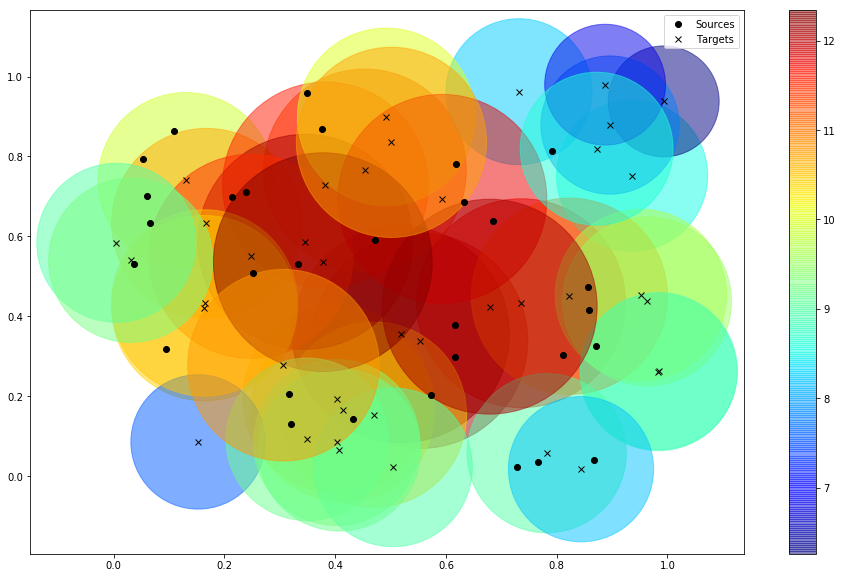

In [31]:
plot(s, t, out['res'])

#### Using *Discrete Gauss Transform*

In [32]:
R = DGT(s, t, parameters['delta'])

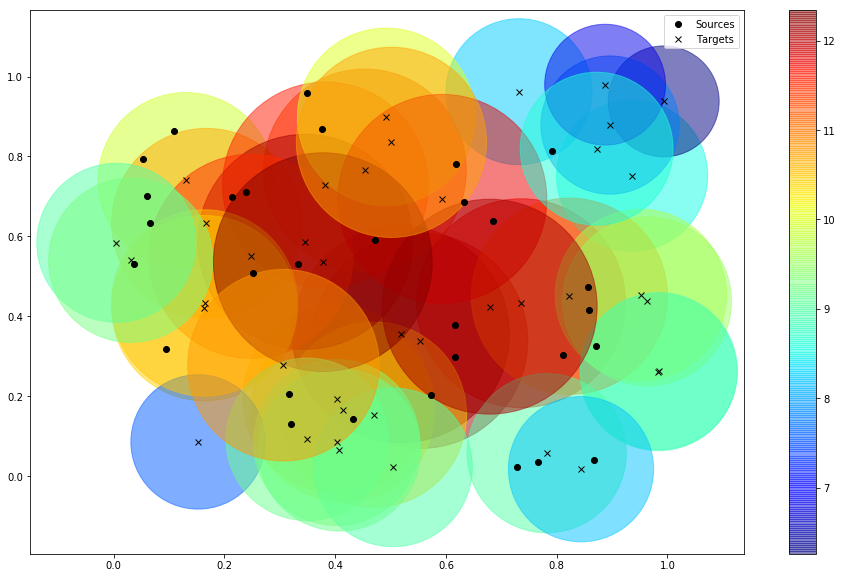

In [33]:
plot(s, t, R)

In [34]:
print("Error:", L2_error(out['res'], R))

Error: 1.92913530362e-16


##### Simulation 2: Equal sources and targets

In [35]:
N = 30
s = gen_sources(N)

In [36]:
parameters = {
    's': s,
    't': s,
    'r': 0.5,
    'delta': .5,
    'N_side': 4,
    'eps': 1e-14
}

##### Using FGT

In [37]:
out = FGT(parameters)

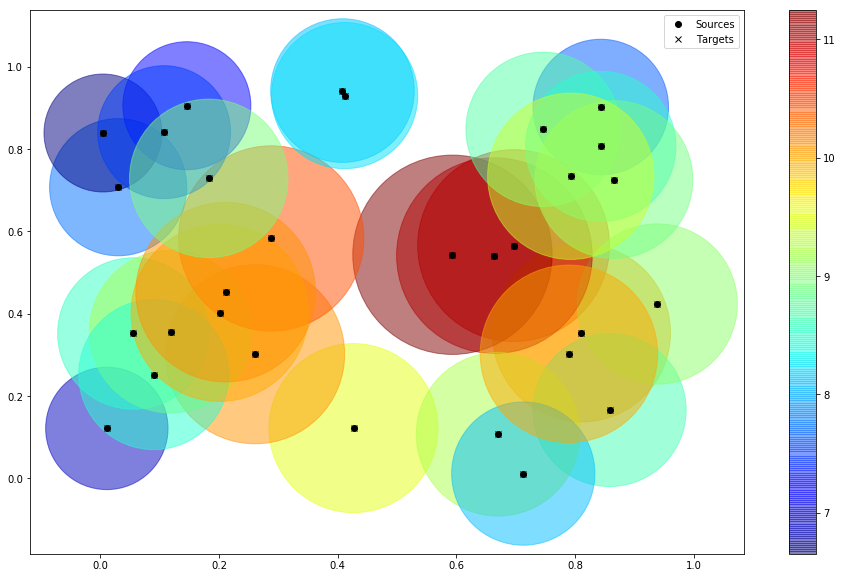

In [38]:
plot(s, s, out['res'])

##### Using DGT

In [39]:
R = DGT(s, s, parameters['delta'])

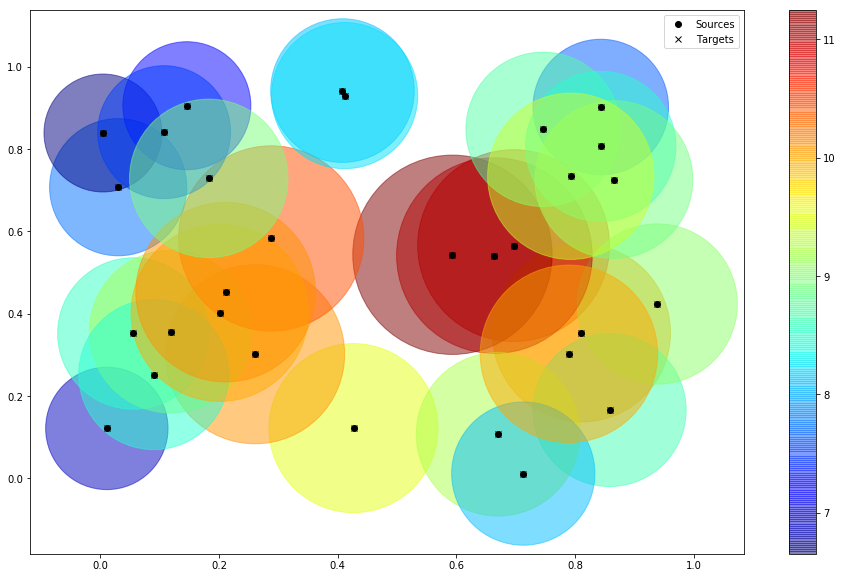

In [40]:
plot(s, s, R)

### Convergence analysis

In [41]:
#N = np.array([10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000, 200000])
#N = np.array([100, 200, 300, 800, 1600, 3200, 6400, 12800, 25600])
N = np.array([800, 1600, 3200, 6400])

error = np.zeros(len(N))

for i in range(len(N)):
    s = gen_sources(N[i])
    t = gen_targets(N[i])
    
    parameters = {
    's': s,
    't': t,
    'r': 0.5,
    'delta': .01,
    'N_side': 4,
    'eps': 1e-14
    }
    
    out = FGT(parameters)
    R = DGT(s, t, parameters['delta'])
    
    error[i] = L2_error(out['res'], R)

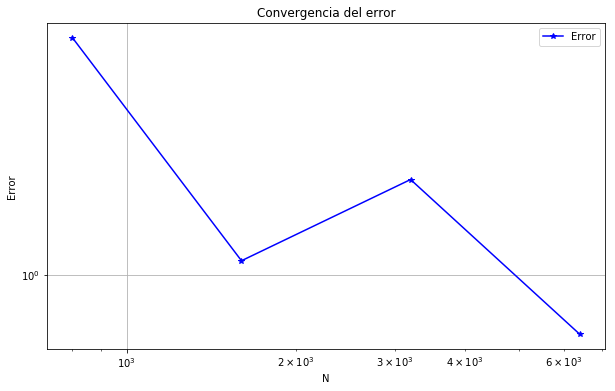

In [42]:
convergence_plot(N, error)

### Complexity analysis

In [43]:
#N = np.array([10**i for i in range(1, 6)])
N = np.array([800, 1600, 3200, 6400])

t_DGT = np.zeros(len(N))
t_FGT = np.zeros(len(N))

for i in range(len(N)):
    s = gen_sources(N[i])
    t = gen_targets(N[i])
    
    parameters = {
    's': s,
    't': t,
    'r': 0.5,
    'delta': .01,
    'N_side': 4,
    'eps': 1e-14
    }
    
    t1 = %timeit -r 1 -n 1 -o -q FGT(parameters)
    t2 = %timeit -r 1 -n 1 -o -q DGT(s, t, parameters['delta'])
    
    t_FGT[i] = t1.best
    t_DGT[i] = t2.best

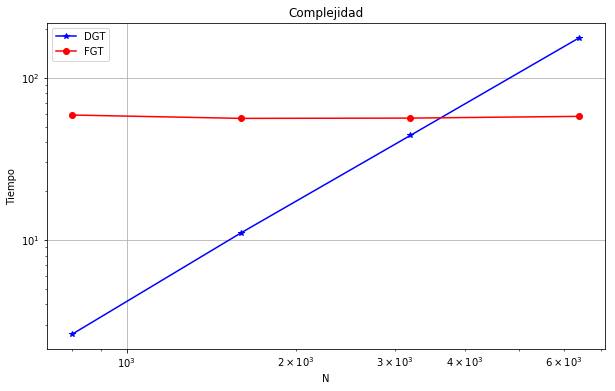

In [44]:
complexity_plot(N, t_DGT, t_FGT)

## 3. Conclusions

* The algorithm decrease the computation time for large problems.

<!--
Del desarrollo del proyecto se obtuvieron las siguientes conclusiones:

* Es posible ver que el uso de métodos relacionados con la FFT (DST), tienen resultados cualitativamente buenos para la resolución de EDP's.
* La complejidad de los algoritmos indican que computacionalmente son métodos eficientes para este tipo de problemas.
* Según el análisis de los gráficos no existe una diferencia significativa en los resultados de cada algoritmo, pero aún así dependerá de los recursos de cómputo disponibles.
* Gracias a la optimización de las librerías para el cálculo de las FFT (DST), es posible obtener resultados en una cantidad de tiempo bastante inferior que aplicando los métodos usuales.
-->

## 4. References 

* [1] Greengard, L., & Strain, J. (1991). The fast Gauss transform. SIAM Journal on Scientific and Statistical Computing, 12(1), 79-94.	
* [2] Yang, C., Duraiswami, R., Gumerov, N. A., & Davis, L. (2003, October). Improved fast gauss transform and efficient kernel density estimation. In null (p. 464). IEEE.